In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
# REQUIRED because your kernel starts at "/"
PROJECT_ROOT = "/Users/srs/Desktop/REGIS/MSDS692- DATA SCIENCE PRACTICUM/practicum_1_mood_detection_using_music_recommendation_system"
os.chdir(PROJECT_ROOT)
print("Working directory set to:", os.getcwd())

Working directory set to: /Users/srs/Desktop/REGIS/MSDS692- DATA SCIENCE PRACTICUM/practicum_1_mood_detection_using_music_recommendation_system


In [3]:
df = pd.read_csv("data/processed/spotify_dataset_with_mood.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (146833, 12)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,source_dataset,mood_label
0,0.941394,1.096577,1.124668,0.0583,0.1020,0.000000,0.0653,0.140773,0.005845,194754,spotify_dataset_1,Happy / Energetic
1,0.813163,0.673558,0.627369,0.0373,0.0724,0.004210,0.3570,0.829455,-0.746595,162600,spotify_dataset_1,Happy / Energetic
2,0.515902,1.159402,0.954713,0.0742,0.0794,0.000023,0.1100,0.514629,0.073096,176616,spotify_dataset_1,Happy / Energetic
3,0.766534,1.155213,0.881023,0.1020,0.0287,0.000009,0.2040,-0.807640,0.003117,169093,spotify_dataset_1,Angry / Intense
4,0.370186,0.748948,0.690623,0.0359,0.0803,0.000000,0.0833,0.955385,0.072005,189052,spotify_dataset_1,Happy / Energetic


In [4]:
feature_cols = ["valence", "energy", "danceability", "tempo", "loudness"]

missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing similarity features: {missing}")

X = df[feature_cols].copy()

In [5]:
X = X.apply(pd.to_numeric, errors="coerce")
valid_mask = X.notna().all(axis=1)

df_model = df.loc[valid_mask].reset_index(drop=True)
X = X.loc[valid_mask].reset_index(drop=True)

print("Model-ready shape:", df_model.shape)

Model-ready shape: (146833, 12)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
nn = NearestNeighbors(n_neighbors=11, metric="cosine")
nn.fit(X_scaled)

print("NearestNeighbors fitted.")

NearestNeighbors fitted.


In [8]:
def display_cols(df_):
    candidates = ["track_name", "track_artist", "playlist_genre", "playlist_name", "mood_label"]
    existing = [c for c in candidates if c in df_.columns]
    if existing:
        return existing + feature_cols
    return ["mood_label"] + feature_cols

In [9]:
def recommend_by_song_index(song_index: int, top_n: int = 10):
    """
    Recommend Top-N similar songs to the given song_index (row index in df_model).
    Uses cosine distance in scaled feature space.
    """
    if song_index < 0 or song_index >= len(df_model):
        raise IndexError(f"song_index out of range. Must be between 0 and {len(df_model)-1}")

    distances, indices = nn.kneighbors([X_scaled[song_index]], n_neighbors=top_n + 1)

    rec_indices = indices[0][1:]
    rec_distances = distances[0][1:]

    recs = df_model.iloc[rec_indices].copy()
    recs["cosine_distance"] = rec_distances
    recs["similarity_score"] = 1 - recs["cosine_distance"]  # optional, intuitive

    # Include the query song info at top (for clarity)
    query = df_model.iloc[[song_index]][display_cols(df_model)].copy()
    recs_out = recs[display_cols(df_model) + ["similarity_score"]].sort_values("similarity_score", ascending=False)

    return query, recs_out

In [10]:
query_song, recs = recommend_by_song_index(song_index=0, top_n=10)
query_song, recs.head(10)

(          mood_label   valence    energy  danceability     tempo  loudness
 0  Happy / Energetic  0.140773  1.096577      0.941394  0.005845  1.124668,
               mood_label   valence    energy  danceability     tempo  \
 29684  Happy / Energetic  0.140773  1.096577      0.941394  0.005845   
 29142  Happy / Energetic  0.128967  0.673558      0.626646  0.038448   
 93657  Happy / Energetic  0.164385  1.318557      1.226998 -0.129747   
 29734  Happy / Energetic  0.160450  1.029564      0.801506  0.108869   
 63799  Happy / Energetic  0.014843  0.736383      0.580017  0.039812   
 83     Happy / Energetic  0.014843  0.736383      0.580017  0.039812   
 29713  Happy / Energetic  0.184062  1.167778      0.865621  0.109040   
 58421  Happy / Energetic  0.132903  0.686123      0.679104  0.005641   
 29790  Happy / Energetic  0.223415  0.970928      0.982194  0.075244   
 93094  Happy / Energetic -0.008769  0.660993      0.585846  0.039027   
 
        loudness  similarity_score  
 2968

In [12]:
 def recommend_by_mood(mood_label: str, top_n: int = 10):
    subset = df_model[df_model["mood_label"] == mood_label]
    if subset.empty:
        raise ValueError(f"No songs found for mood_label={mood_label}")


    prototype = subset[feature_cols].mean(axis=0).values.reshape(1, -1)
    prototype_scaled = scaler.transform(prototype)

    distances, indices = nn.kneighbors(prototype_scaled, n_neighbors=top_n)

    recs = df_model.iloc[indices[0]].copy()
    recs["cosine_distance"] = distances[0]
    recs["similarity_score"] = 1 - recs["cosine_distance"]

    return recs[display_cols(df_model) + ["similarity_score"]].sort_values("similarity_score", ascending=False)

In [16]:
def plot_neighbors(song_index: int, top_n: int = 10):
   
    query, recs = recommend_by_song_index(song_index, top_n)
    

    distances, indices = nn.kneighbors([X_scaled[song_index]], n_neighbors=top_n + 1)
    neighbor_indices = indices[0][1:]
    
 
    query_point = df_model.iloc[song_index]
    
    plt.figure(figsize=(8, 6))
    

    plt.scatter(df_model["valence"], df_model["energy"], 
                alpha=0.1, s=10, label="All Songs")
    

    neighbors = df_model.iloc[neighbor_indices]
    plt.scatter(neighbors["valence"], neighbors["energy"], 
                color="green", s=50, label="Nearest Neighbors")
    
    plt.scatter(query_point["valence"], query_point["energy"], 
                color="red", s=120, label="Query Song")
    
    plt.xlabel("Valence")
    plt.ylabel("Energy")
    plt.title(f"Nearest Neighbors for Song Index {song_index}")
    plt.legend()
    plt.tight_layout()
    plt.show()

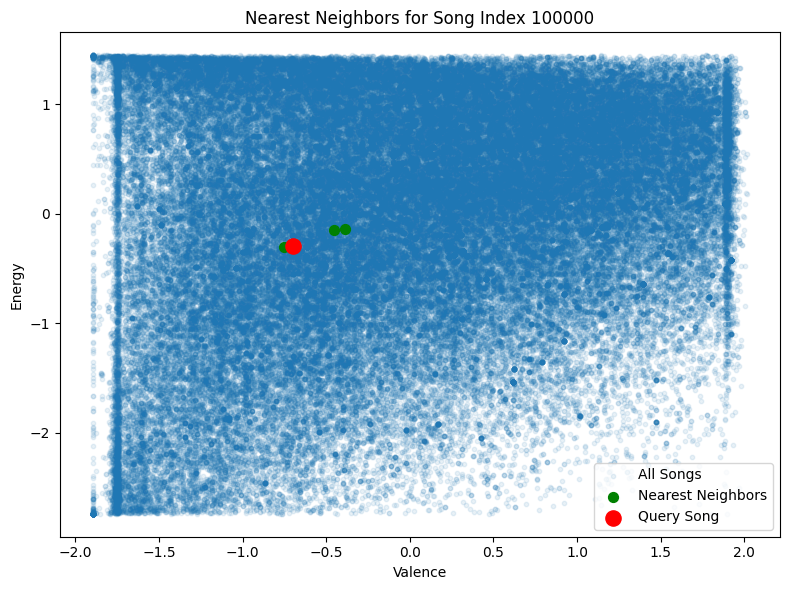

In [20]:
plot_neighbors(song_index=100000, top_n=10)


In [13]:
recommend_by_mood("Happy / Energetic", top_n=10).head(10)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,mood_label,valence,energy,danceability,tempo,loudness,similarity_score
3985,Happy / Energetic,1.053768,0.899727,0.294413,0.104538,0.613100,0.998658
93449,Happy / Energetic,1.498460,1.318557,0.614989,0.277029,0.955778,0.998649
29536,Happy / Energetic,1.262340,1.096577,0.492587,0.141369,0.830761,0.998413
2694,Happy / Energetic,1.262340,1.096577,0.492587,0.141369,0.830761,0.998413
5134,Happy / Energetic,1.262340,1.096577,0.492587,0.141369,0.830761,0.998413
32293,Happy / Energetic,1.262340,1.096577,0.492587,0.141369,0.830761,0.998413
111472,Happy / Energetic,1.553554,1.230603,0.585846,0.279076,0.968344,0.998291
96188,Happy / Energetic,1.120669,0.878785,0.352700,0.110165,0.580301,0.998153
38404,Happy / Energetic,1.120669,0.878785,0.352700,0.110165,0.580301,0.998153
95643,Happy / Energetic,1.120669,0.878785,0.352700,0.110165,0.580301,0.998153


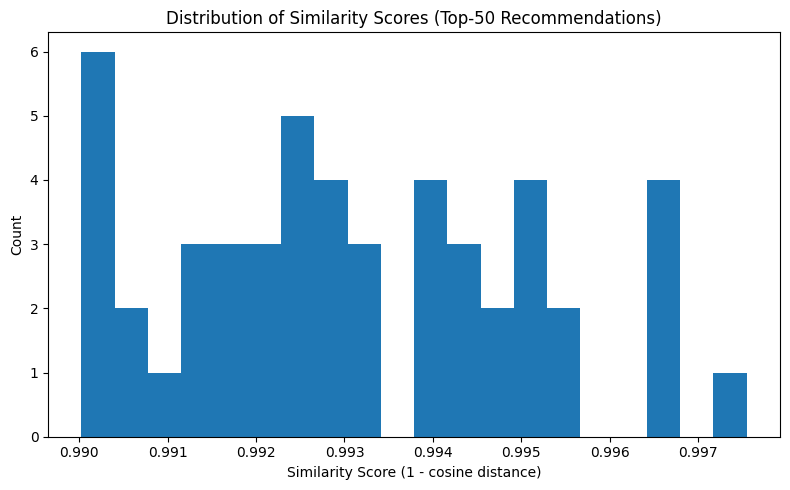

In [19]:
_, recs = recommend_by_song_index(song_index=3, top_n=50)

plt.figure(figsize=(8, 5))
plt.hist(recs["similarity_score"], bins=20)
plt.xlabel("Similarity Score (1 - cosine distance)")
plt.ylabel("Count")
plt.title("Distribution of Similarity Scores (Top-50 Recommendations)")
plt.tight_layout()
plt.show()

In [15]:
os.makedirs("reports", exist_ok=True)

# Save one example
query_song, recs10 = recommend_by_song_index(song_index=0, top_n=10)
recs10.to_csv("reports/week4_example_recommendations_song0.csv", index=False)

# Save mood example
mood_recs = recommend_by_mood("Happy / Energetic", top_n=10)
mood_recs.to_csv("reports/week4_example_recommendations_happy_energetic.csv", index=False)

print("Saved example recommendation CSVs into reports/")

Saved example recommendation CSVs into reports/


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
